# Practica 2 - Aprenentatge automátic

En aquesta segona práctica explorarem diferents models de machine learning, on amb el dataset de Oxford-IIIT Pet Dataset crearem models per a la classificació de cans i moxios, per a la classificació de races, la segmentació dels caps dels animals i finalment de la segmentació dels cosos dels animals.

Per aquesta práctica emprarem Google Colab degut a les limitacions de les nostres tarjetes gráfiques a alguns models que emprarem durant aquesta práctica.

Les mesures de epochs i learning rate sempre seran les mateixes, 10 epocs y un learning rate de 1e-3.

Começarem per carregar el dataset i fer un analisis inicial de les nostres dades.

---

Carregam el notre repositori a l'instància de Colab i entram a la carpeta de la segon práctica.

**Important**: L'instància ha de tenir disponible una gráfica!

In [3]:
!git clone https://github.com/multiparedes/AprenentatgeAutomatic.git
%cd AprenentatgeAutomatic/p2
!ls

Cloning into 'AprenentatgeAutomatic'...
remote: Enumerating objects: 23130, done.
remote: Counting objects: 100% (4676/4676), done.
remote: Compressing objects: 100% (4624/4624), done.
remote: Total 23130 (delta 57), reused 4652 (delta 51), pack-reused 18454
Receiving objects: 100% (23130/23130), 863.85 MiB | 36.43 MiB/s, done.
Resolving deltas: 100% (3736/3736), done.
Updating files: 100% (30514/30514), done.
/content/AprenentatgeAutomatic/p2
annotations  images  practica2.ipynb


Si Colab et dona un error de 'Cuda Out of Memory' executa aquesta celda per cridar al garbaje colector i lliberar memoria que ha quedat bloquetjada.

In [ ]:
import gc
gc.collect()

56

Aquest bloc inclou les llibreries que emprarem durant l'execució de la práctica.

In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv

from matplotlib.image import imread
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

# Visualització dinàmica de les dades.
import pylab as pl
from IPython import display
from tqdm import tqdm

# Introduïm una seed manual per a reproduibïlitat.
torch.manual_seed(33)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import warnings
warnings.filterwarnings('ignore')

Primer de tot crearem un objecte per a generar el nostre dataset, les imatges dels cans i moixos estan dins la carpeta *images*, un ca es diferencia d'un moix per la primera lletra si es majuscula o no, amés tenim un archiu .txt on tenim les anotacions per cada imatge amb les següents columnes:
- Class id: Un id per cada classe d'animal, necessari per diferenciar les diferentes races.
- Species: Id per indicar si es tracte d'un moix, 0, o un ca, 1,
- Breed id: Semblant al class id pero només per la raça a la qual pertany l'animal.

In [ ]:
import pandas as pd

images_path = 'images/'
annotations_path = 'annotations/list.txt'

with open(annotations_path, 'r') as file:
    lines = [line.split() for line in file if not line.startswith('#')]

columns = ["Image", "CLASS-ID", "SPECIES", "BREED ID"]
df = pd.DataFrame(lines, columns=columns)

df["Image"] = images_path + df["Image"] + '.jpg'
df["CLASS-ID"] = df["CLASS-ID"].astype('int64')
df["SPECIES"] = df["SPECIES"].astype('int64')
df["BREED ID"] = df["BREED ID"].astype('int64')

numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].apply(lambda x: x - 1)

print(df)

                                Image  CLASS-ID  SPECIES  BREED ID
0           images/Abyssinian_100.jpg         0        0         0
1           images/Abyssinian_101.jpg         0        0         0
2           images/Abyssinian_102.jpg         0        0         0
3           images/Abyssinian_103.jpg         0        0         0
4           images/Abyssinian_104.jpg         0        0         0
...                               ...       ...      ...       ...
7344  images/yorkshire_terrier_96.jpg        36        1        24
7345  images/yorkshire_terrier_97.jpg        36        1        24
7346  images/yorkshire_terrier_98.jpg        36        1        24
7347  images/yorkshire_terrier_99.jpg        36        1        24
7348   images/yorkshire_terrier_9.jpg        36        1        24

[7349 rows x 4 columns]


Cal remarcar l'imporatancia de com s'han guardat les dades, les variables numeriques han de ser de típus int64, i han d'anar de 0 fins n, si comencen a 1 l'entrenament fallarà.

Ara que ja tenim el nostre dataset amb els paths i les imatges pertinents anam a veure com es la distribució de cans i moixos.

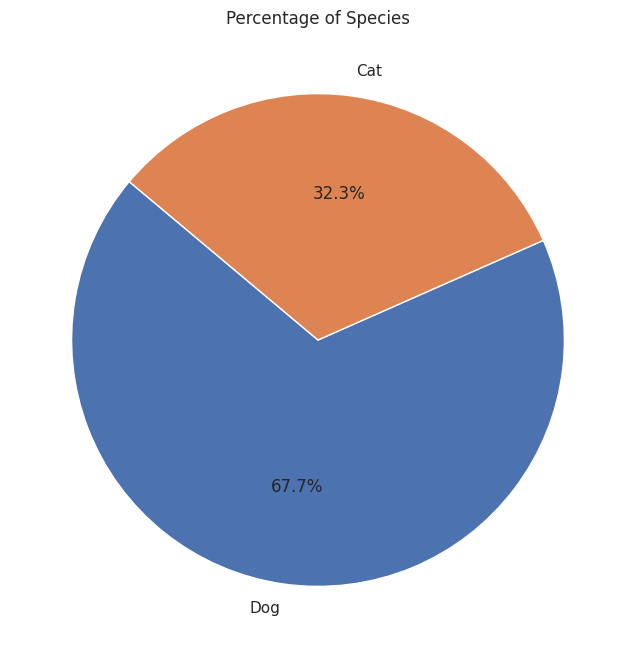

In [ ]:
species_counts = df['SPECIES'].map({0: 'Cat', 1: 'Dog'}).value_counts()

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.title('Percentage of Species')
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

Com podem observar la distribució de cans i moixos no es balancetjada, per solucionar aquest problema i obtenir millors resultats de cara a l'entrenament farem un augment de dades de la categoria dels moixos, duplicant files fins obtenir un 50/50 de les dues classes.

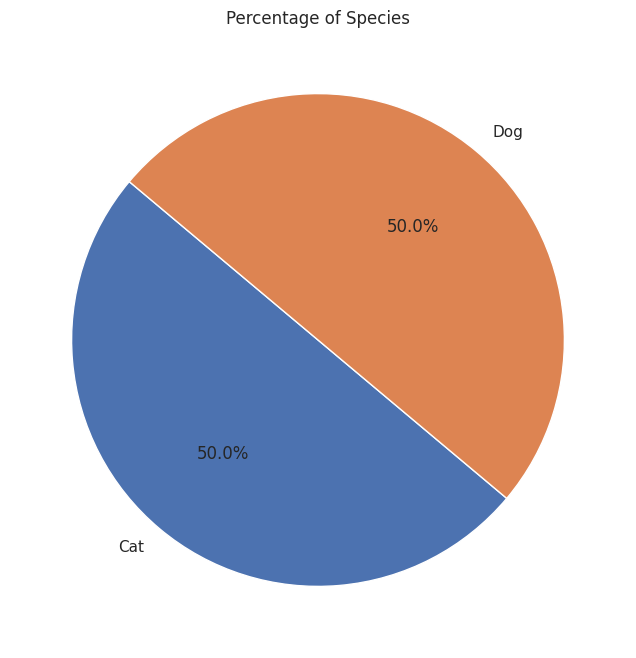

9956

In [ ]:
cats_df = df[df['SPECIES'] == 0]
dogs_df = df[df['SPECIES'] == 1]

max_samples = max(len(cats_df), len(dogs_df))
cats_upsampled = resample(cats_df, replace=True, n_samples=max_samples, random_state=42)

df_balanced = pd.concat([cats_upsampled, dogs_df])

species_counts = df_balanced['SPECIES'].map({0: 'Cat', 1: 'Dog'}).value_counts()

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.title('Percentage of Species')
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

len(df_balanced)

Com podem observar la distribució de cans i moixos ja es balancetjada, el que veurem a continuació es la distribució de les diferentes races per veure si es necesari alguna modificació.

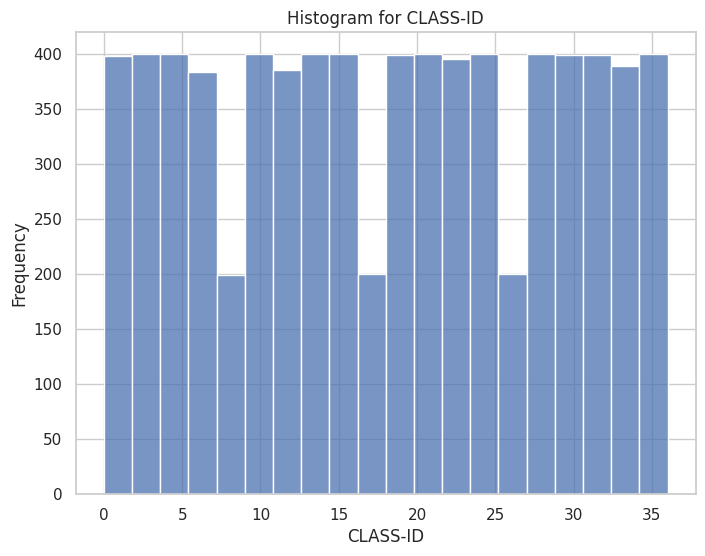

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="CLASS-ID", bins=20, kde=True)
plt.title('Histogram for CLASS-ID')
plt.xlabel('CLASS-ID')
plt.ylabel('Frequency')
plt.show()

# 1) Classifiació d'espècie

## 1.1) Creant una red CCN pròpia.

Per aquest primer apartat crearem una red convolucional pròpia, el que hem de fer primer de tot es crear el dataset, per això agafarem les dades del dataframe i les separarem en train i test, reservant un 20% de les mostres per test.

A continuació crearem l'objecte que fara de dataset i crearem els data loaders per tenir els batches d'entrenament i validació amb una mida de 32.

Amés aplicarem técniques de augmentació de dades per a tenir més imatges, crearem un segon dataset on les imatges estaran alterades de manera aleatoria de la següent manera:
- RandomHorizontalFlip: El 50% de les vegades les imatges estaran com si les miresim a través d'un mirall.
- ColorJitter: Variacións dels 20% del color aprofintant que són imatges en RGB.
- RandomRotation: Aplicam una rotació aleatoria entre 0 i 180 graus.

In [ ]:
X = df_balanced[["Image"]]
y = df_balanced[["SPECIES"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]
        label = self.labels.iloc[index]

        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor()])

data_augmentations = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor()
])

train_ds = ConcatDataset([DogsCats(train_df['Image'], train_df['SPECIES'], transform), DogsCats(train_df['Image'], train_df['SPECIES'], data_augmentations)])
train_dl = DataLoader(train_ds, batch_size=32)

test_ds = DogsCats(test_df['Image'], test_df['SPECIES'], transform)
test_dl = DataLoader(test_ds, batch_size=32)

iterador =  iter(train_dl)

Una vegada tenim els datasets i els dataloaders creats podem mirar les dimensions de les nostres dades, ens serà útil per a la creació de la xarxa convolucional i comprovar que no ens hem equivocant creant els batches.

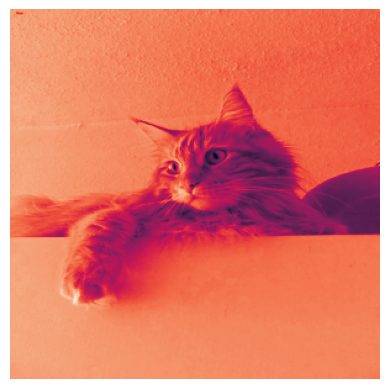

Etiqueta: 0
Feature batch shape: torch.Size([32, 3, 300, 300])
Labels batch shape: torch.Size([32])


In [ ]:
features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()

print(f"Etiqueta: {labels[0].item()}")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

A continuació anam a crear la nostra xarxa la qual constara de 4 capes convolucionals i 3 capes denses, aplicant relu com a funció d'acitvació i dropout al 50%, amés aplicarem capes de MaxPooling entre capa convolucionals per a millorar la mida de la xarxa.

In [ ]:
from collections import OrderedDict

class SuperCNNSuperGuay(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(SuperCNNSuperGuay, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, 5, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(5, 10, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(24*18*18, 200)
        self.linear_2 = nn.Linear(200, 10)
        self.linear_3 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.conv_1(x)
        x = self.max_pool2d(x)
        x = self.relu(x)

        x = self.conv_2(x)
        x = self.max_pool2d(x)
        x = self.relu(x)

        x = self.conv_3(x)
        x = self.max_pool2d(x)
        x = self.relu(x)

        x = self.conv_4(x)
        x = self.max_pool2d(x)
        x = self.dropout(x)
        x = self.relu(x)


        x = torch.flatten(x, 1)
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.linear_2(x)
        x = self.relu(x)

        x = self.linear_3(x)

        return F.log_softmax(x, dim=1)

class SuperFCNSuperGuay(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, init_features=32):
        super(SuperFCNSuperGuay, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv_5 = nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool(x)

        x = self.relu(self.conv_2(x))

        x = self.relu(self.conv_3(x))
        x = self.max_pool(x)

        x = self.relu(self.conv_4(x))

        x = self.relu(self.conv_5(x))
        x = self.dropout(x)

        x = self.avg_pool(x)

        return x.squeeze()

A continuació anam a provar que tal funciona la nostra xarxa amb el conjunt d'entrenament, aplicarem un script semblant als que hem vist a clase amb visualització dinàmica de la funció de perdua, com hem dit abans farem 10 epochs amb un learning rate de 1e-3.

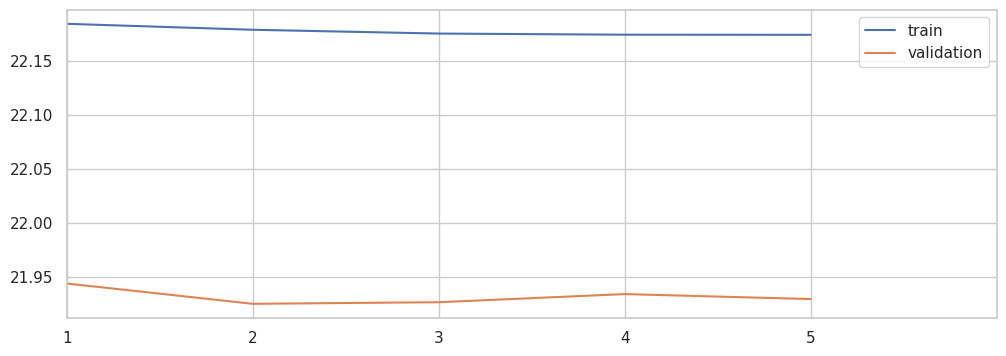

Epoch:5 Training Loss:22.17424003570434 Validation Loss:21.92954827868749: 100%|██████████| 5/5 [07:38<00:00, 91.70s/it]


In [ ]:
use_cuda = True
torch.manual_seed(33)
model = SuperCNNSuperGuay().to(device)

epochs = 10
lr = 1e-3

optimizer = Adam(model.parameters(), lr=lr)

t_loss = np.zeros((epochs))
v_loss = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
for epoch in pbar:

    train_loss = 0
    val_loss = 0

    model.train()
    for batch_num, (input_img, target) in enumerate(train_dl, 1):
        input_img= input_img.to(device)
        optimizer.zero_grad()

        target = target.to(device)
        output = model(input_img)

        loss = F.cross_entropy(output, target, reduction='sum')
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # RESULTATS
    train_loss /= len(train_dl)
    t_loss[epoch-1] = train_loss

    val_loss /= len(test_dl)
    v_loss[epoch-1] = val_loss

    # VISUALITZACIO DINAMICA
    plt.figure(figsize=(12, 4))
    pl.plot(t_loss[:epoch], label="train")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))

    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()

    pbar.set_description(f"Epoch:{epoch} \nTraining Loss:{train_loss}\n")

Una vegada ha acabat l'entrenament mirarem que tal funciona sobre el conjunt de validació, per això crearem una funció la qual ens retornarà la precissió i ens dibuixarà una matriu de confusió.

Checking accuracy on Test Set


100%|██████████| 63/63 [00:08<00:00,  7.50it/s]


Accuracy: 49.10%


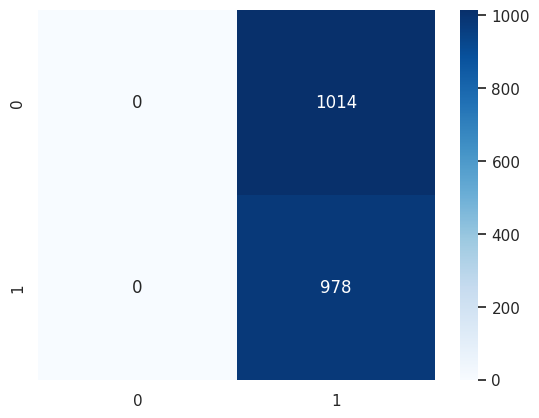

In [ ]:
from sklearn.metrics import confusion_matrix

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)

            # Collect true and predicted labels for the confusion matrix
            all_true_labels.extend(y.cpu().numpy())
            all_predicted_labels.extend(predictions.cpu().numpy())

        accuracy = num_correct / num_samples
        print(f"Accuracy: {accuracy * 100:.2f}%")

    model.train()

    class_names = list(set(all_true_labels + all_predicted_labels))
    sns.heatmap(confusion_matrix(all_true_labels, all_predicted_labels), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

## 1.2) Model preentrenat, Inception V3

In [ ]:
import torch
import torch.nn as nn
import torchvision

class InceptionModel(nn.Module):
    def __init__(self):
        super(InceptionModel, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.inception_v3(pretrained=True)
        in_features = self.base_model.fc.in_features

        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=12),
        )

    def forward(self, x):
        return self.base_model(x)

model_inception = InceptionModel()
model_inception.to(device)

print('Inception loaded')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 31.9MB/s]


Inception loaded


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        scores = model(data)
        logits = scores.logits

        loss = criterion(logits, targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

498it [04:38,  1.79it/s]


Cost at epoch 0 is 0.262444218755307


498it [04:42,  1.76it/s]


Cost at epoch 1 is 0.16875923521340783


498it [04:40,  1.77it/s]


Cost at epoch 2 is 0.13776889079617174


498it [04:40,  1.78it/s]


Cost at epoch 3 is 0.11767808863604216


498it [04:41,  1.77it/s]


Cost at epoch 4 is 0.10886199404083446


498it [04:39,  1.78it/s]


Cost at epoch 5 is 0.09589906679034485


498it [04:40,  1.78it/s]


Cost at epoch 6 is 0.08896512422539073


498it [04:40,  1.77it/s]


Cost at epoch 7 is 0.07891181201984251


498it [04:40,  1.78it/s]


Cost at epoch 8 is 0.078430576825554


498it [04:41,  1.77it/s]

Cost at epoch 9 is 0.06998693306784289


Checking accuracy on Test Set


100%|██████████| 63/63 [00:20<00:00,  3.11it/s]


Accuracy: 98.95%


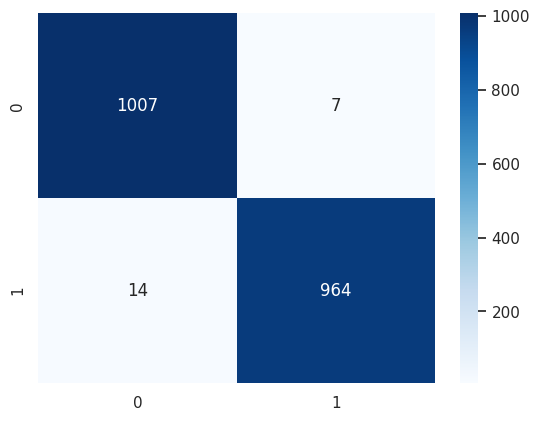

In [ ]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

In [ ]:
train_it = iter(train_dl)

In [ ]:
data, label = next(train_it)
photo = data[0][0]
class_mapping = {0: 'Cat', 1: 'Dog'}

# # Convert data to float
# data = data.float()

# # Add a batch dimension at the beginning
# data = data.unsqueeze(0)
data = data.to(device=device,dtype=torch.float)
# data = data.to(device=device,dtype=torch.float)
score = model(data)
_, predictions = score.logits.max(1)

original = class_mapping.get(label[0].item(), "Unknown")
prediction = class_mapping.get(predictions[0].item(), "Unknown")

plt.imshow(photo)
plt.axis("off")
plt.title(f"Original class: {original} | Predicted as: {prediction}")
plt.show()


NameError: name 'train_it' is not defined

In [ ]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

import random

# Get the maximum index in the DataFrame
max_index = len(df) - 1

# Generate a random index between 1 and max_index
i = random.randint(1, max_index)

# Load an image from a file path
image_path = df.iloc[i]['Image']
image = Image.open(image_path).convert("RGB")

# Apply the transform to preprocess the image
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the input image to the appropriate device
input_image = input_image.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Forward pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_image)
    # Interpret the model's output
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class_index = torch.argmax(probabilities).item()
    predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")

    # Display the original image and show the predicted class
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted class: {predicted_class_name}")
    plt.show()
    print(output[0])


### Proves amb fotos a local

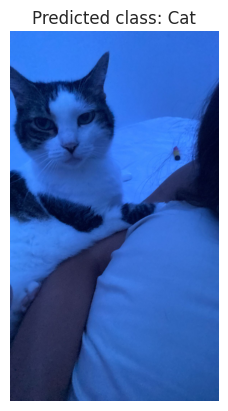

tensor([ 1.5201, -0.8538], device='cuda:0')


In [ ]:
# Load an image from a file path
image_path = 'ainoa.jpeg'
image = Image.open(image_path).convert("RGB")
class_mapping = {0: 'Cat', 1: 'Dog'}

# Apply the transform to preprocess the image
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the input image to the appropriate device
input_image = input_image.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Forward pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_image)
    # Interpret the model's output
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class_index = torch.argmax(probabilities).item()
    predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")

    # Display the original image and show the predicted class
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted class: {predicted_class_name}")
    plt.show()
    print(output[0])


# 2) Classificació per raça

In [ ]:
X = df_balanced[["Image"]]
y = df_balanced[["CLASS-ID"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor()])

data_augmentations = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor()
])

train_ds = ConcatDataset([DogsCats(train_df['Image'], train_df['CLASS-ID'], transform), DogsCats(train_df['Image'], train_df['CLASS-ID'], data_augmentations)])
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['CLASS-ID'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl)

In [ ]:
features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()

print(f"Etiqueta: {labels[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

In [ ]:
import torch
import torch.nn as nn
import torchvision

class InceptionModelCatBreed(nn.Module):
    def __init__(self):
        super(InceptionModelCatBreed, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)

        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=64, out_features=37, bias=True)
        )


    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
model = InceptionModelCatBreed()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Inception loaded')

In [ ]:
learning_rate = 1e-3
num_epochs = 15

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

In [ ]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

## Segona idea

### Cat breed classifier

In [ ]:
cats_df = df_balanced[df_balanced['SPECIES'] == 0]
dogs_df = df_balanced[df_balanced['SPECIES'] == 1]

X = cats_df[["Image"]]
y = cats_df[["BREED ID"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        #label = torch.tensor(label)

        return image, label


transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor()])

data_augmentations = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor()
])

train_ds = ConcatDataset([DogsCats(train_df['Image'], train_df['BREED ID'], transform), DogsCats(train_df['Image'], train_df['BREED ID'],  data_augmentations)])
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['BREED ID'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl)

                                Image  CLASS-ID  SPECIES  BREED ID
2410      images/Egyptian_Mau_165.jpg        11        0         5
4186             images/Bengal_19.jpg         5        0         1
3472           images/Siamese_200.jpg        32        0        10
3437           images/Siamese_163.jpg        32        0        10
4629  images/British_Shorthair_62.jpg         9        0         4
...                               ...       ...      ...       ...
2411      images/Egyptian_Mau_168.jpg        11        0         5
354             images/Bombay_104.jpg         7        0         3
2850        images/Maine_Coon_171.jpg        20        0         6
3761         images/Abyssinian_85.jpg         0        0         0
1304           images/Ragdoll_110.jpg        26        0         8

[4978 rows x 4 columns]


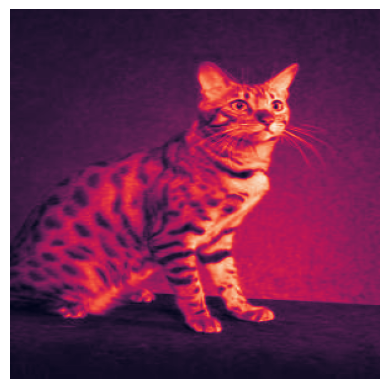

Etiqueta: 1
Saber l'estructura del batch us ajudarà: 
Feature batch shape: torch.Size([64, 3, 300, 300])
Labels batch shape: torch.Size([64])


In [ ]:
features, label = next(iterador)
print(cats_df)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()

print(f"Etiqueta: {label[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {label.size()}")

In [ ]:
class InceptionModelCatBreed(nn.Module):
    def __init__(self):
        super(InceptionModelCatBreed, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)

        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=12),
        )


    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
catBreed = InceptionModelCatBreed()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
catBreed.to(device)

print('Inception loaded')

NameError: name 'torchvision' is not defined

In [ ]:
learning_rate = 1e-3
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(catBreed.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = catBreed(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

In [ ]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, catBreed)

### Dog Breed Model


In [ ]:
X = dogs_df[["Image"]]
y = dogs_df[["BREED ID"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor()])

data_augmentations = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor()
])

train_ds = ConcatDataset([DogsCats(train_df['Image'], train_df['BREED ID'], transform), DogsCats(train_df['Image'], train_df['BREED ID'], data_augmentations)])
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['BREED ID'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl)

In [ ]:
features, label = next(iterador)
print(cats_df)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()

print(f"Etiqueta: {label[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {label.size()}")

In [ ]:


class InceptionModelDogBreed(nn.Module):
    def __init__(self):
        super(InceptionModelDogBreed, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)

        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=25),
            )


    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
dogBreed = InceptionModelDogBreed()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dogBreed.to(device)

print('Inception loaded')

In [ ]:
learning_rate = 1e-3
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(dogBreed.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = dogBreed(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

In [ ]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, dogBreed)

In [ ]:
X = df_balanced[["Image"]]
y = df_balanced.iloc[:, -2:]
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        print(labels.iloc(0)[0])
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc(0)[index].values
        # Read image using PIL
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((300, 300)),
                                transforms.ToTensor()])

# a =train_df.iloc[:, -2:]
# print(train_df.iloc(0)[0])
# print(a.iloc(0)[0])

train_ds = DogsCats(train_df['Image'], train_df.iloc[:, -2:], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df.iloc[:, -2:], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl)

In [ ]:
data, breed_label = next(iterador)
photo = data[0][0]
race_label = label[0][0].item()
breed_label = label[0][1].item()

plt.imshow(photo)
plt.axis("off")
plt.title(f"Race: {race_label} Breed: {breed_label}")
plt.show()

# # Convert data to float
# data = data.float()

# # Add a batch dimension at the beginning
# data = data.unsqueeze(0)
data = data.to(device=device,dtype=torch.float)
# data = data.to(device=device,dtype=torch.float)
score = model(data)
_, predictions = score.max(1)
race_prediction = predictions[0].item()
print("RacePredictions:",race_prediction)

breed_prediction = -1
if(race_prediction == 0):
    catScore = catBreed(data)
    _, predictions = catScore.max(1)
    breed_prediction = predictions[0].item()
else:
    dogScore = dogBreed(data)
    _, predictions = dogScore.max(1)
    breed_prediction = predictions[0].item()

print(breed_prediction)

## 3) Deteció de cares - Yolo

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
!pip install -r yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
# Source: https://blog.paperspace.com/train-yolov5-custom-data/
# Function to get the data from XML Annotation
folder_path = "annotations/coco"  # Update to your Colab folder path
import xml.etree.ElementTree as ET

# Create output folder if it doesn't exist
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict

folder_path = "annotations/xmls/"

# Get all file paths in the folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

# Print the list of file paths
# for file_path in file_paths:
#     # print(extract_info_from_xml(file_path))

# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"cat": 0,
                           "dog": 1, }

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join("annotations/coco", info_dict["filename"].replace("jpg", "txt"))

    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))


# Convert and save the annotations
for ann in tqdm(file_paths):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)

# annotations = [os.path.join('annotations/yolo', x) for x in os.listdir('annotations/yolo') if x[-3:] == "txt"]

100%|██████████| 3686/3686 [00:00<00:00, 8319.44it/s]


annotations/coco/basset_hound_188.txt
images/basset_hound_188.jpg


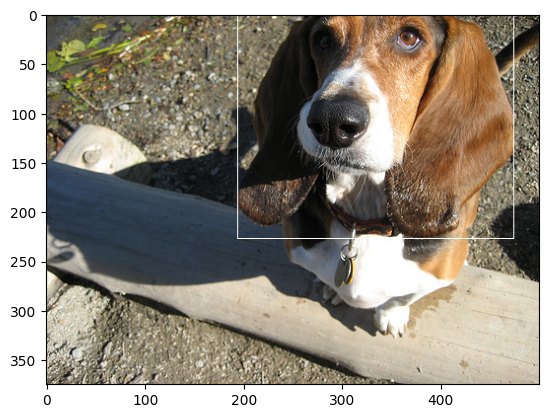

In [ ]:
import random
from PIL import ImageDraw

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
coco_folder_path = "annotations/coco/"
coco_file_paths = [os.path.join(coco_folder_path, file) for file in os.listdir(coco_folder_path) if os.path.isfile(os.path.join(coco_folder_path, file))]

annotation_file = random.choice(coco_file_paths)
print(annotation_file)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("/coco","").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
import os
import shutil

def copiar_archivos_si_existen(origen, destino, tercera_carpeta, extension=".xml"):
    try:
        # Comprueba si la carpeta de destino existe, y si no, la crea
        if not os.path.exists(destino):
            os.makedirs(destino)

        # Lista los archivos en la tercera carpeta con la extensión especificada
        archivos = [f for f in os.listdir(tercera_carpeta) if f.endswith(extension)]
        # Copia cada archivo a la carpeta de destino
        for archivo in archivos:
            ruta_origen = os.path.join(origen, archivo.replace("xml","jpg"))
            ruta_destino = os.path.join(destino, archivo.replace("xml","jpg"))
            shutil.copy(ruta_origen, ruta_destino)
            # print(f"Archivo '{archivo}' copiado de '{origen}/{tercera_carpeta}' a '{destino}'")

        print("Operación completada.")
    except Exception as e:
        print(f"Error: {e}")

# Especifica la carpeta de origen, la carpeta de destino y la tercera carpeta
carpeta_origen = "images"
carpeta_destino = "obj_detection/head_annotated_imgs"
tercera_carpeta = os.path.join("annotations", "xmls")

# Llama a la función para copiar archivos si existen en la tercera carpeta
copiar_archivos_si_existen(carpeta_origen, carpeta_destino, tercera_carpeta)

Operación completada.


In [ ]:
# Read images and annotations
images = [os.path.join('obj_detection/head_annotated_imgs', x) for x in os.listdir('obj_detection/head_annotated_imgs')]
annotations = [os.path.join('annotations/coco', x) for x in os.listdir('annotations/coco') if x[-3:] == "txt"]

images.sort()
print(len(images))
annotations.sort()
print(len(annotations))

# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

3686
3686


In [ ]:
#Utility function to move images
def move_files_to_folder(file_list, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        destination_path = os.path.join(target_folder, file_name)
        shutil.move(file_path, destination_path)

# Move the splits into their folders
move_files_to_folder(train_images, 'obj_detection/images/train')
move_files_to_folder(val_images, 'obj_detection/images/val/')
move_files_to_folder(test_images, 'obj_detection/images/test/')
move_files_to_folder(train_annotations, 'obj_detection/labels/train/')
move_files_to_folder(val_annotations, 'obj_detection/labels/val/')
move_files_to_folder(test_annotations, 'obj_detection/labels/test/')

In [ ]:
!python yolov5/train.py --img 640 --cfg yolov5s.yaml  --batch 32 --epochs 1 --data yolov5/cat_dogs_data.yaml --weights yolov5/yolov5s.pt --workers 24 --name cats_dogs
print('Yolo trained!')

2024-01-08 15:17:44.055821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 15:17:44.055881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 15:17:44.057686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5/yolov5s.pt, cfg=yolov5s.yaml, data=yolov5/cat_dogs_data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, dev

In [ ]:
!python yolov5/detect.py --source obj_detection/images/test/ --weights yolov5/runs/train/cats_dogs/weights/best.pt --conf 0.05 --name cats_dogs

detect: weights=['yolov5/runs/train/cats_dogs/weights/best.pt'], source=obj_detection/images/test/, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.05, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=cats_dogs, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-269-gad97dc6 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/369 /content/AprenentatgeAutomatic/p2/obj_detection/images/test/Abyssinian_117.jpg: 544x640 2 cats, 3 dogs, 82.2ms
image 2/369 /content/AprenentatgeAutomatic/p2/obj_detection/images/test/Abyssinian_125.jpg: 480x640 3 cats, 50.1ms
image 3/

In [ ]:
!python yolov5/val.py --weights yolov5/runs/train/cats_dogs/weights/best.pt --data yolov5/cat_dogs_data.yaml --task test --name yolo_det

val: data=yolov5/cat_dogs_data.yaml, weights=['yolov5/runs/train/cats_dogs/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-267-gc42aba5 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/AprenentatgeAutomatic/p2/obj_detection/labels/test... 369 images, 0 backgrounds, 0 corrupt: 100% 369/369 [00:00<00:00, 1817.56it/s]
test: New cache created: /content/AprenentatgeAutomatic/p2/obj_detection/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0% 0/12 [00:00<?, ?it/s]Corrupt JPEG data: premature end of data segment
               

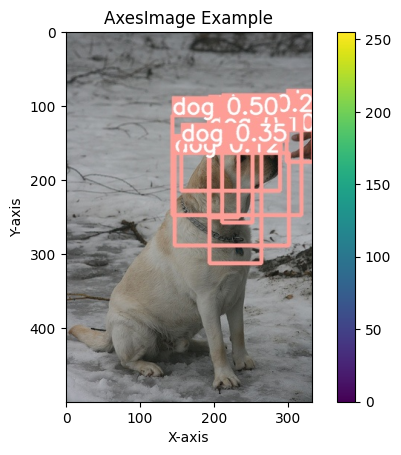

In [ ]:
detections_dir = "yolov5/runs/detect/cats_dogs3"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]


random_detection_image = Image.open(random.choice(detection_images)).convert("RGB")
import matplotlib.pyplot as plt
import numpy as np

# Create a sample image (you can replace this with your own image data)
image_data = random.choice(detection_images)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the image using AxesImage
im = ax.imshow(random_detection_image, cmap='viridis')

# Show the colorbar (optional)
cbar = plt.colorbar(im)

# Add labels and title (optional)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('AxesImage Example')

# Show the plot
plt.show()

In [ ]:
!python yolov5/val.py --weights yolov5/runs/train/cats_dogs/weights/best.pt --data yolov5/cat_dogs_data.yaml --task test --name yolo_det

val: data=yolov5/cat_dogs_data.yaml, weights=['yolov5/runs/train/cats_dogs/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-269-gad97dc6 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/AprenentatgeAutomatic/p2/obj_detection/labels/test... 369 images, 0 backgrounds, 0 corrupt: 100% 369/369 [00:00<00:00, 1882.54it/s]
test: New cache created: /content/AprenentatgeAutomatic/p2/obj_detection/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0% 0/12 [00:00<?, ?it/s]Corrupt JPEG data: premature end of data segment
               

In [ ]:
!python yolov5/detect.py --weights yolov5/runs/train/cats_dogs/weights/best.pt --source https://www.youtube.com/watch?v=GywtvatoybI                              # webcam


detect: weights=['yolov5/runs/train/cats_dogs/weights/best.pt'], source=https://www.youtube.com/watch?v=GywtvatoybI, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-269-gad97dc6 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

1/1: https://www.youtube.com/watch?v=GywtvatoybI...  Success (2700 frames 720x1280 at 30.00 FPS)

0: 640x384 (no detections), 700.0ms
WARNING ⚠️ NMS time limit 0.550s exceeded
0: 640x384 1 dog, 14.1ms
0:

## 4) Segmentació dels animals - SAM

In [1]:
#!pip install git+https://github.com/facebookresearch/segment-anything.git
#!pip install transformers
!pip install transformers===4.33.1
#!pip install datasets
#!pip install -q monai
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
#!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-j9hmcuh2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-j9hmcuh2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=3658

In [5]:
import pandas as pd
import os

images_path = 'images/'
annotations_path = 'annotations/list.txt'
masks_path = 'annotations/trimaps/'

with open(annotations_path, 'r') as file:
    lines = [line.split() for line in file if not line.startswith('#')]

columns = ["Image", "CLASS-ID", "SPECIES", "BREED ID"]
df_segm = pd.DataFrame(lines, columns=columns)

df_segm["Mask"] = masks_path + df_segm["Image"] + '.png'
df_segm["Image"] = images_path  + df_segm["Image"] + '.jpg'
df_segm = df_segm[["Mask", "Image"]]

print(df_segm)

                                              Mask  \
0           annotations/trimaps/Abyssinian_100.png   
1           annotations/trimaps/Abyssinian_101.png   
2           annotations/trimaps/Abyssinian_102.png   
3           annotations/trimaps/Abyssinian_103.png   
4           annotations/trimaps/Abyssinian_104.png   
...                                            ...   
7344  annotations/trimaps/yorkshire_terrier_96.png   
7345  annotations/trimaps/yorkshire_terrier_97.png   
7346  annotations/trimaps/yorkshire_terrier_98.png   
7347  annotations/trimaps/yorkshire_terrier_99.png   
7348   annotations/trimaps/yorkshire_terrier_9.png   

                                Image  
0           images/Abyssinian_100.jpg  
1           images/Abyssinian_101.jpg  
2           images/Abyssinian_102.jpg  
3           images/Abyssinian_103.jpg  
4           images/Abyssinian_104.jpg  
...                               ...  
7344  images/yorkshire_terrier_96.jpg  
7345  images/yorkshire_terrier_

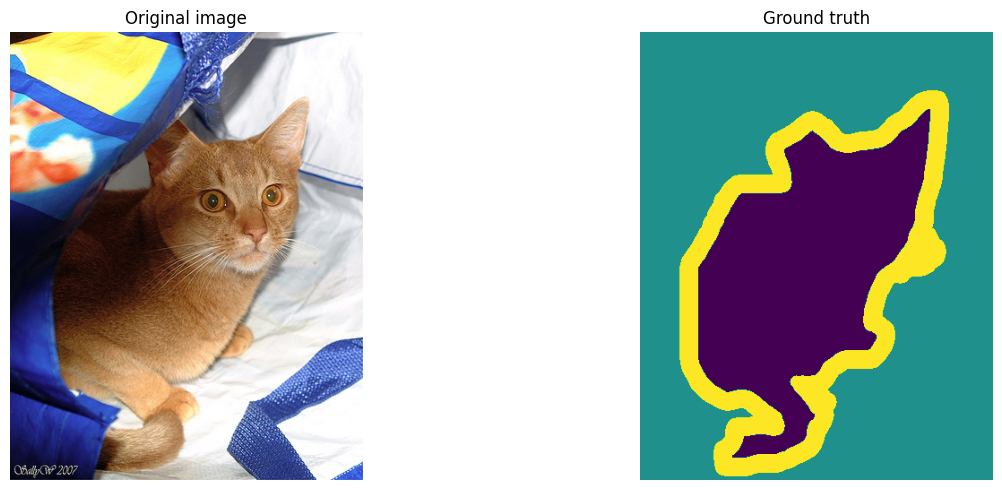

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

image = df_segm.iloc[0]

mask_image = Image.open(image['Mask'])
original_image = Image.open(image['Image'])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(original_image)
axes[0].set_title("Original image")
axes[0].axis('off')

axes[1].imshow(mask_image)
axes[1].set_title("Ground truth")
axes[1].axis('off')

plt.tight_layout()
plt.show()

- 1 means "pet"
- 2 means "background"
- 3 means "border"

Let's delete images that dont have any real bounding box

In [7]:
rows_to_remove = []

for index, row in df_segm.iterrows():
    mask_path = row["Mask"]
    mask_image = np.array(Image.open(mask_path))

    # Check if the mask has any pixel value other than 2
    if not np.any(mask_image != 2):
        rows_to_remove.append(index)

# Remove rows from the DataFrame
df_filtered = df_segm.drop(rows_to_remove)

In [10]:
from datasets import Dataset
from PIL import Image
from torchvision import transforms
import numpy as np

# Assuming 'df_filtered' is your DataFrame with "Image" and "Mask" columns
# Note: Adjust column names based on your actual DataFrame structure

# Define a transformation to resize images to 300 x 300
resize_transform = transforms.Resize((256, 256))

# Load images and masks from paths
df_filtered["image"] = [resize_transform(Image.open(img_path)) for img_path in df_filtered["Image"]]
df_filtered["label"] = [resize_transform(Image.open(mask_path)) for mask_path in df_filtered["Mask"]]

# Convert to NumPy arrays
df_filtered["image"] = [np.array(img) for img in df_filtered["image"]]
df_filtered["label"] = [np.array(mask) for mask in df_filtered["label"]]

# Create the dataset
dataset_dict = {
    "image": [Image.fromarray(img) for img in df_filtered["image"]],
    "label": [Image.fromarray(mask) for mask in df_filtered["label"]],
}

dataset = Dataset.from_dict(dataset_dict)

# Display the dataset
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 7335
})


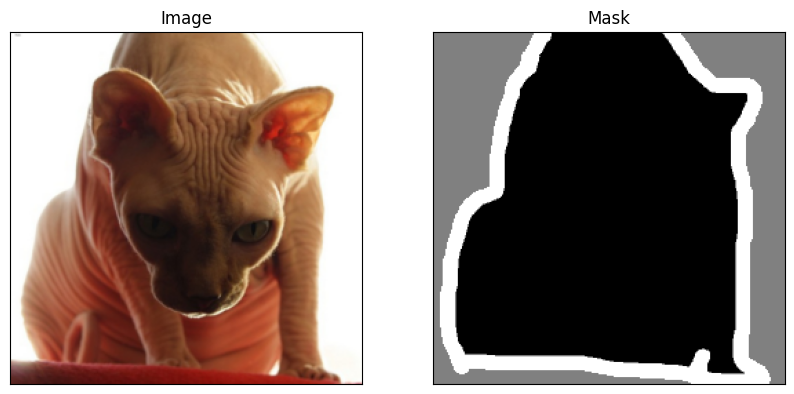

In [11]:
import random

img_num = random.randint(0, df_filtered.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [12]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [13]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]


        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        # Map original values to new values
        ground_truth_mask = np.where(ground_truth_mask == 2, 0, ground_truth_mask)  # Map 2 to 0 (Background)
        ground_truth_mask = np.where(ground_truth_mask == 1, 1, ground_truth_mask)  # Map 1 to 1 (Pet)
        ground_truth_mask = np.where(ground_truth_mask == 3, 1, ground_truth_mask)  # Map 3 to 1 (Pet)

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [14]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
train_dataset = SAMDataset(dataset=dataset, processor=processor)

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [15]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [16]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [17]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-3, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [18]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# Training loop
num_epochs = 1
num_batches_to_train = len(train_dataloader)/4

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []

    # Limit the number of batches to train on
    for batch_idx, batch in enumerate(tqdm(train_dataloader)):
        if batch_idx >= num_batches_to_train:
            break

        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

 25%|██▌       | 917/3668 [16:41<50:04,  1.09s/it]

EPOCH: 0
Mean loss: 0.3025314462825152


In [19]:
#torch.save(model.state_dict(), "/contents/dog_cats_sam_model_checkpoint.pth")
torch.save(model.state_dict(), './checkpoint.pth')



---

Recuperar + Inferencia

In [22]:
from transformers import SamModel, SamConfig, SamProcessor
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
sam_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.


In [23]:
keys = torch.load("checkpoint.pth", map_location=torch.device('cpu'))
sam_model.load_state_dict(keys)

<All keys matched successfully>

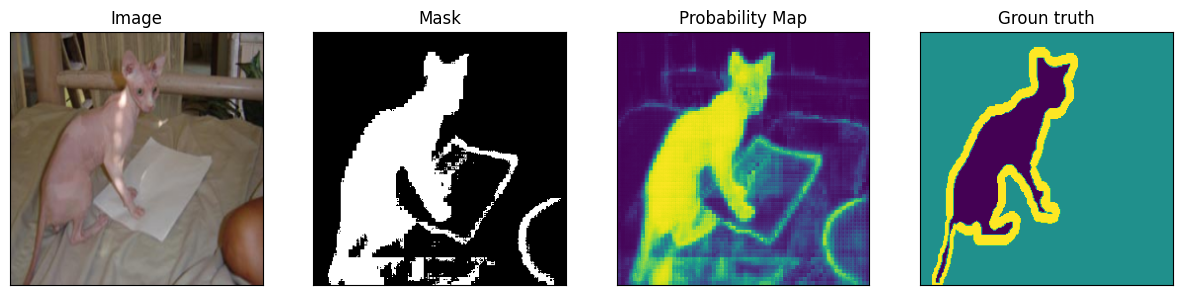

In [32]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, df_filtered.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

sam_model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image))
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)
axes[2].set_title("Probability Map")

# Plot the second image on the right
axes[3].imshow(ground_truth_mask)
axes[3].set_title("Groun truth")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()